# Plot along-gene mutation rates

Of genes we're interested in in CAMP. But we could of course generalize this / show multiple genes at once.

In [1]:
%run "Header.ipynb"
%run "LoadMutationJSONData.ipynb"
%run "GeneUtils.ipynb"

## Define utility functions for plotting

In [2]:
def plot_gene_mutation_spectrum(seq, leftend, rightend, cutoff=None):
    """leftend must be < rightend -- so if this is a reverse gene,
    the end position should still be leftend, I think.
    
    "cutoff" can optionally be a float. If cutoff is not None, then this'll print out
    information about the number of positions where the percentage of mismatches is >= cutoff.
    (Mostly useful for adding to figure captions...)
    """
    one_cycle_through = False
    gene_positions = range(leftend, rightend + 1)
    cp = 1
    num_called_mutations = 0
    # We adopt the strategy here of calling pyplot.scatter() for each data point to plot, rather than
    # building up lists of x-axis, y-axis, and color values and plotting that. See e.g.
    # https://stackoverflow.com/questions/42180475#comment71523984_42180475 for documentation on this.
    for p in gene_positions:
        sp = str(p)
        cov = seq2pos2mismatchct[seq][sp] + seq2pos2matchct[seq][sp]
        pct = seq2pos2mismatchct[seq][sp] / cov
        # If we assign a label to every datapoint, then the duplicate labels show up in the legend.
        # To avoid this, we just only assign labels to the first three points at a codon position:
        # https://stackoverflow.com/a/19386045.
        label = "" if one_cycle_through else "Codon Position {}".format(cp)
        pyplot.scatter(p, pct, c=cp2color[cp], label=label, edgecolor=BORDERCOLOR)
        if cp == 3:
            cp = 1
            one_cycle_through = True
        else:
            cp += 1
        if cutoff is not None and pct >= cutoff:
            num_called_mutations += 1
    
    if cutoff is not None:
        print("{} / {} positions have a mismatch rate >= the cutoff of {}".format(
            num_called_mutations, len(gene_positions), cutoff
        ))

    pyplot.title("Mutation spectrum of a gene (left end: {:,}, right end: {:,}) in CAMP".format(leftend, rightend))
    pyplot.xlabel("Sequence position")
    # https://stackoverflow.com/a/27474400
    pyplot.ylabel("$\dfrac{Mismatches}{Mismatches + Matches}$")
    pyplot.ylim(0)
    pyplot.legend()
    
    # Disable "offset" on the x-axis. This prevents matplotlib from replacing literal sequence positions with
    # smaller numbers and then adding a "+1.21e6" off to the side of the axis (which is... a lot more confusing
    # for this particular application than just listing the actual sequence positions). Doing this *after* the
    # percentage thing below doesn't seem to work, but doing it up here works. I dunno, matplotlib is hard.
    # See https://stackoverflow.com/a/28373421.
    pyplot.ticklabel_format(useOffset=False)
    
    # Make the y-axis show percentages: based on
    # https://old.reddit.com/r/learnpython/comments/7adhnk/matplotlib_setting_y_axis_labels_to_percent_yaxis/dp93fwq/
    pyplot.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
    
    # Use thousands separator on the x-axis
    use_thousands_sep(pyplot.gca().xaxis)
    
    # Make figure wide: https://stackoverflow.com/a/4306340
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(15, 5)

In [3]:
def plot_gene_coverage(seq, leftend, rightend):
    gene_positions = range(leftend, rightend + 1)
    one_cycle_through = False
    cp = 1
    for p in gene_positions:
        cov = seq2pos2totalcov[seq][str(p)]
        label = "" if one_cycle_through else "Codon Position {}".format(cp)
        pyplot.scatter(p, cov, c=cp2color[cp], label=label, edgecolor=BORDERCOLOR)
        if cp == 3:
            cp = 1
            one_cycle_through = True
        else:
            cp += 1

    pyplot.title("Coverage across a gene (left end: {:,}, right end: {:,}) in CAMP".format(leftend, rightend))
    pyplot.xlabel("Sequence position")
    pyplot.ylabel("Number of reads aligned to this position")
    pyplot.legend()
    pyplot.ticklabel_format(useOffset=False)
    use_thousands_sep(pyplot.gca().xaxis)
    use_thousands_sep(pyplot.gca().yaxis)
    # Make figure wide: https://stackoverflow.com/a/4306340
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(15, 5)

## Along-gene mutation rates for gene 1217 in CAMP (which exhibits "binarized" mutation rates)
The reason we go with this gene is it stood out really clearly in an earlier version of this analysis, where we were using the scaffold for CAMP rather than a single edge. It's still an outlier in the plot, just not the you know hugest one. That's understandable -- we've changed a lot about the way we process the data throughout the span of this project.

34 / 1149 positions have a mismatch rate >= the cutoff of 0.14


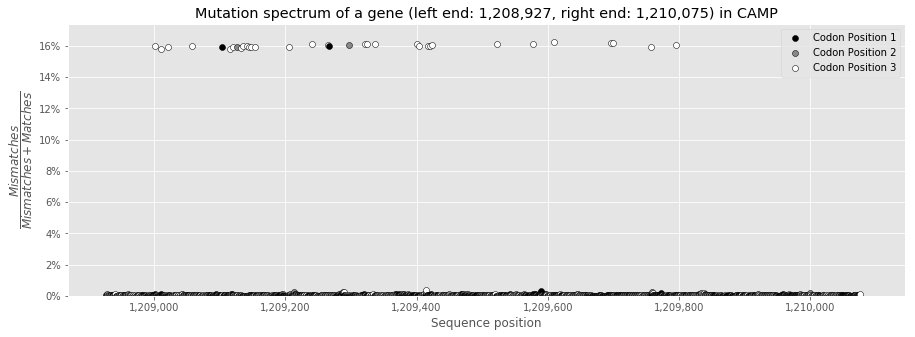

In [4]:
# We pass cutoff=0.14 so the function will count the number of positions above a 14% mutation rate
# The "center" is obvs closer to 16%, but to be careful and make sure we count everything we set it to 14%
plot_gene_mutation_spectrum("edge_6104", 1208927, 1210075, cutoff=0.14)

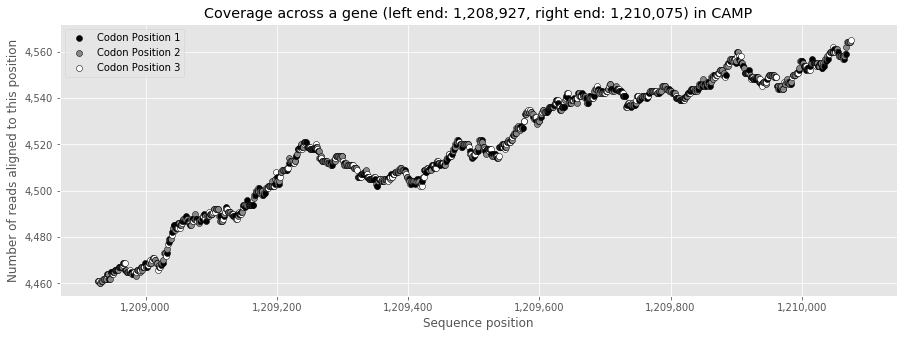

In [5]:
plot_gene_coverage("edge_6104", 1208927, 1210075)

## Along-gene mutation rates for gene 206 in CAMP (less clearly defined pattern)

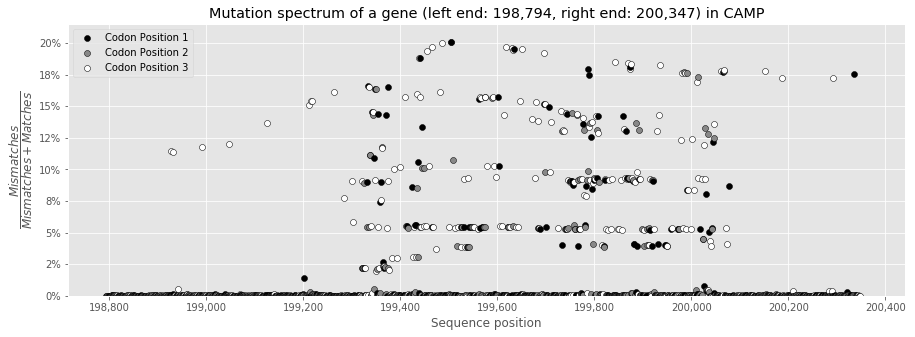

In [6]:
# The gene we're going to plot here is number 206.
plot_gene_mutation_spectrum("edge_6104", 198794, 200347)

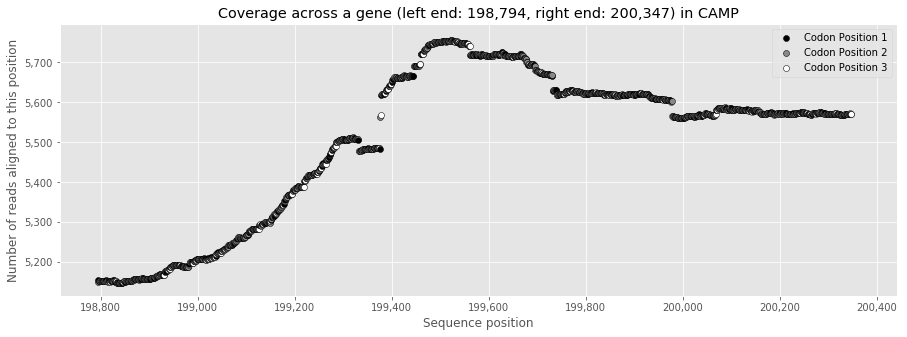

In [7]:
plot_gene_coverage("edge_6104", 198794, 200347)